In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import timedelta
tqdm.pandas()

from scorers.persuasion import *
from scorers.cleaning import *

# Forewords

In [91]:
forewords = pd.read_csv('manifesto-forewords/manifestos.csv')
forewords.year = pd.to_datetime(forewords.year)

In [44]:
# We can analyse forewords as a whole
clean_forewords_whole = forewords.foreword.progress_apply(lambda x: clean(x))
cfw_persuasion_scores = [measure_persuasion(clean_foreword) for clean_foreword in clean_forewords_whole]
cfw_persuasion_vecs = [list(score_dict.values()) for score_dict in cfw_persuasion_scores]

100%|████████████████████████████████████| 76/76 [00:00<00:00, 1670.77it/s]


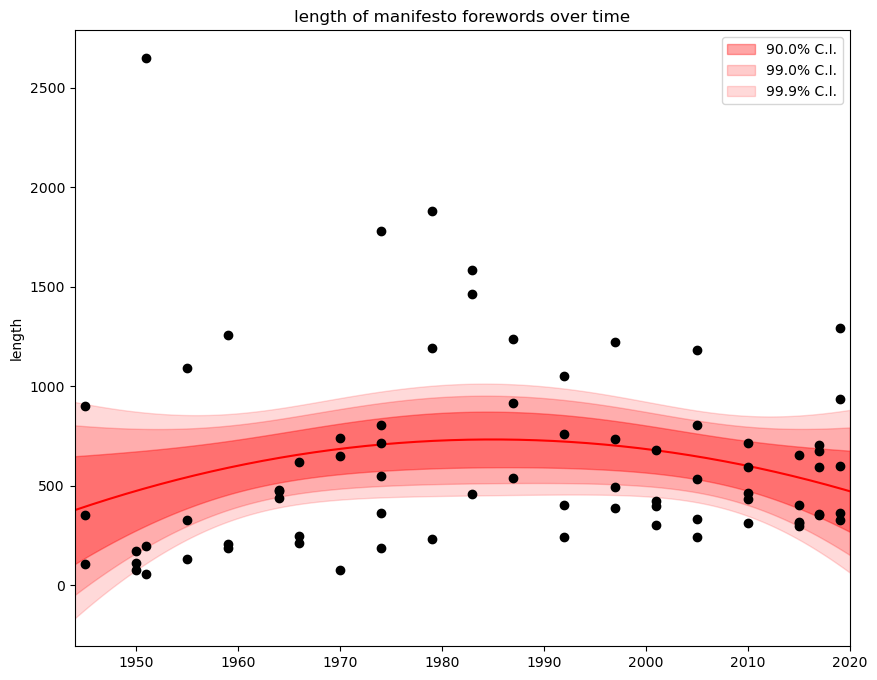

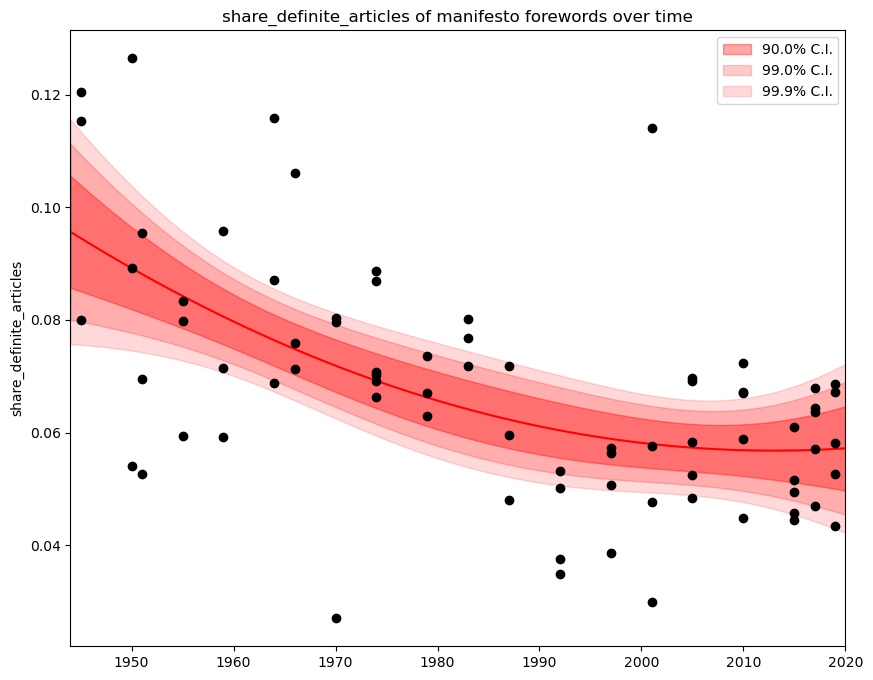

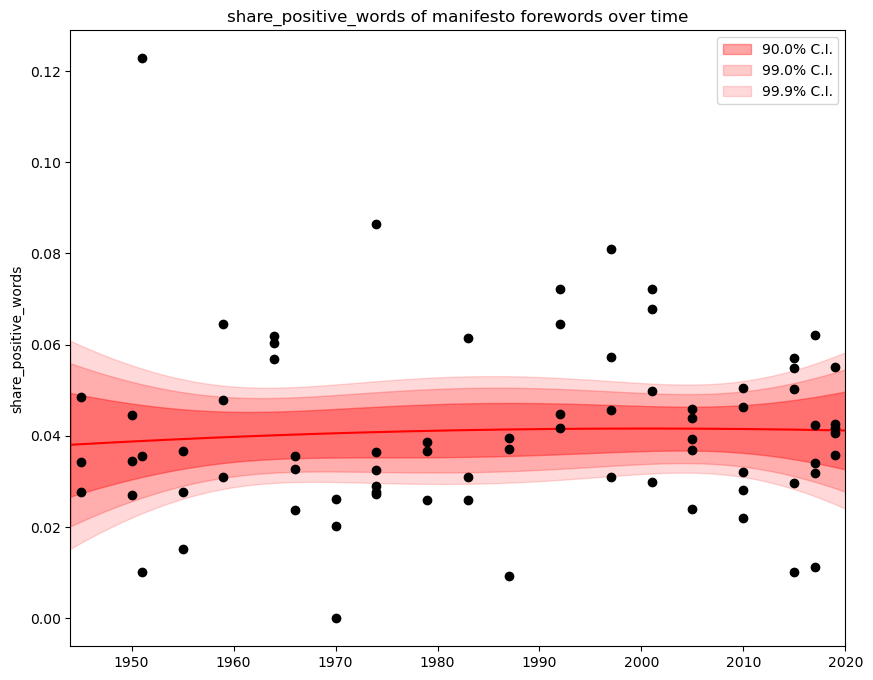

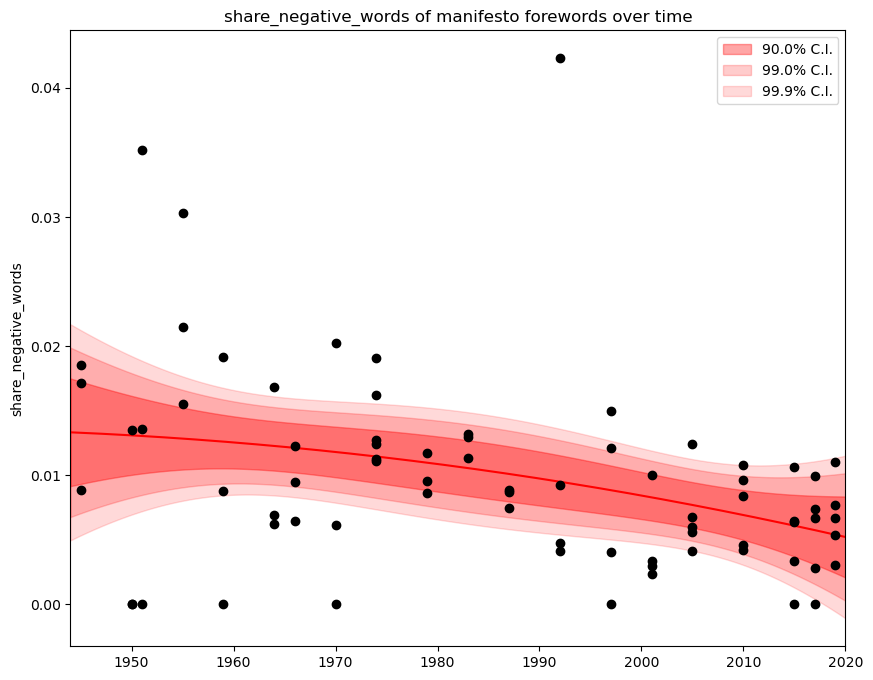

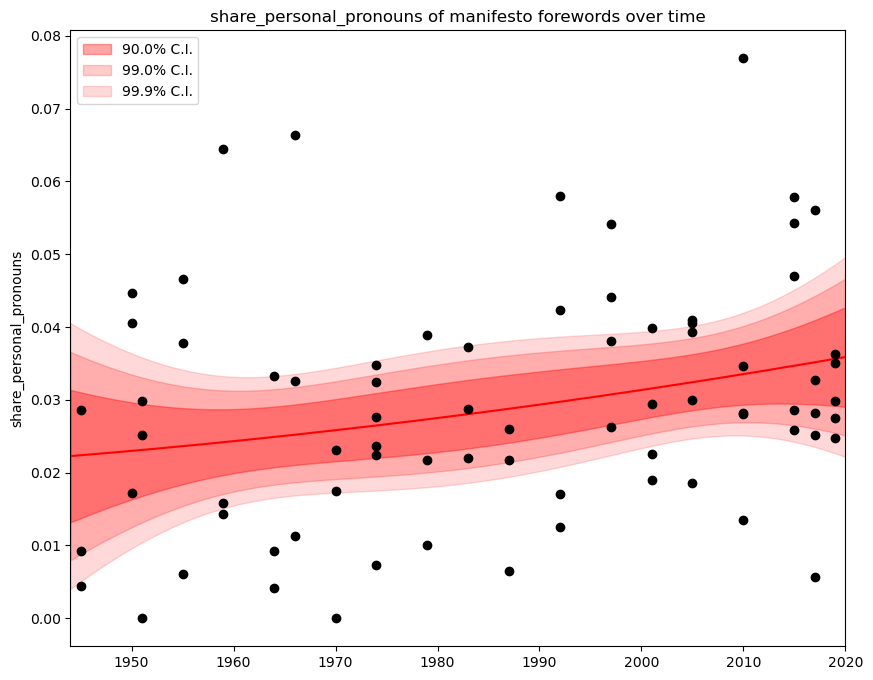

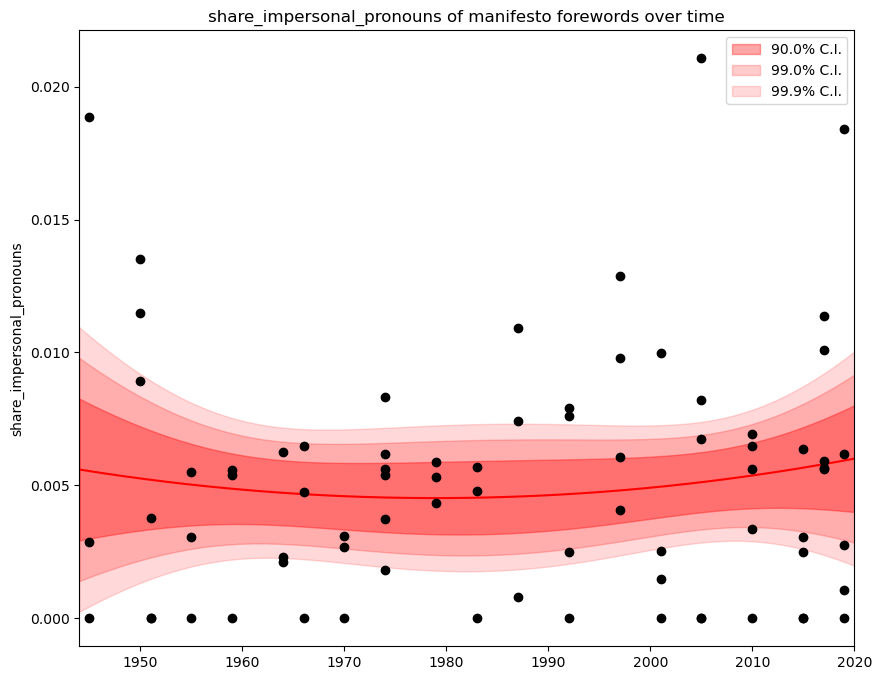

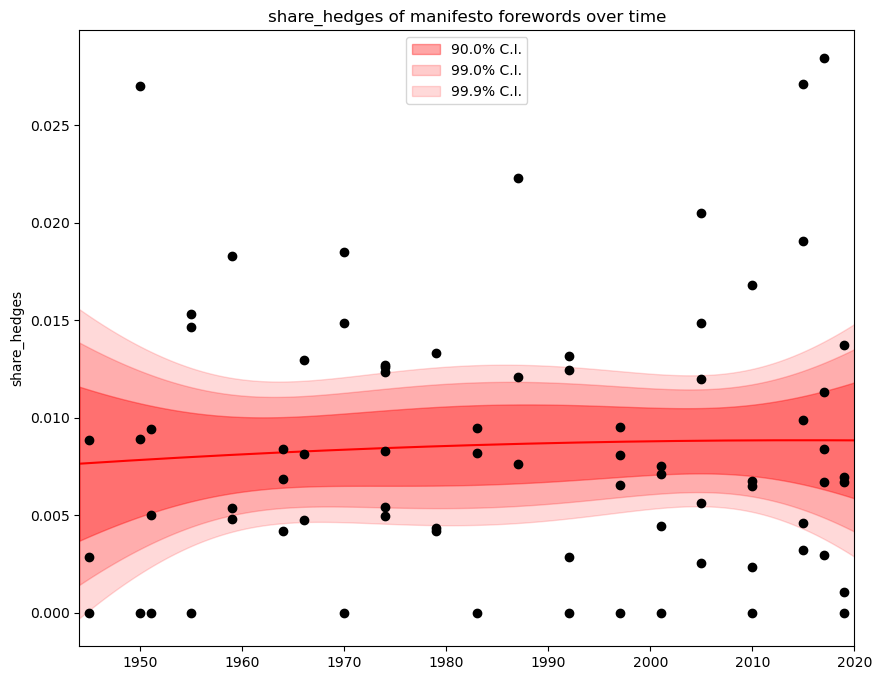

In [71]:
scoring_vars = cfw_persuasion_scores[0].keys()

alpha = 0.05

for scoring_var in scoring_vars:
    conf2alpha = {90.0:1.64,
                  95.0:1.96,
                  99.0:2.58,
                  99.9:3.29}
    
    deg = 2
    x = np.array([year.year for year in forewords.year])
    y = np.array([score_dict[scoring_var] for score_dict in cfw_persuasion_scores])
    coefs,cov = np.polyfit(x, y, deg=deg, cov=True)
    
    xseq = np.linspace(min(x)-1, max(x)+1, num=500)
    
    XX = np.vstack([xseq**(deg-i) for i in range(deg+1)]).T # rows 1, x, x**2, ...
    yseq = np.dot(XX, coefs)  # matrix multiplication by coefs calculates the polynomial values
    y_var = np.dot(XX, np.dot(cov, XX.T)) # y_var = XX*C_x*XX'
    y_sig = np.sqrt(np.diag(y_var))  # std. dev. are sqrt of diagonal  
    
    fig,ax = plt.subplots(1, figsize=(10,8))
    ax.fill_between(xseq, yseq+(conf2alpha[90.0]*y_sig), yseq-(conf2alpha[90.0]*y_sig), alpha=.35, color='red', label='90.0% C.I.')
#     ax.fill_between(xseq, yseq+(conf2alpha[95.0]*y_sig), yseq-(conf2alpha[95.0]*y_sig), alpha=.25, color='red', label='95.0% C.I.')
    ax.fill_between(xseq, yseq+(conf2alpha[99.0]*y_sig), yseq-(conf2alpha[99.0]*y_sig), alpha=.20, color='red', label='99.0% C.I.')
    ax.fill_between(xseq, yseq+(conf2alpha[99.9]*y_sig), yseq-(conf2alpha[99.9]*y_sig), alpha=.15, color='red', label='99.9% C.I.')
    ax.plot(xseq, yseq, color='red')
    ax.plot(x, y, 'o', color='black')
    ax.set_xlim(min(x)-1, max(x)+1)
    ax.set_ylabel(scoring_var)
    ax.set_title(scoring_var+" of manifesto forewords over time")
    plt.legend()
    plt.show()

# PMQs answers

In [109]:
pmqs = pd.read_csv('hansard-pmqs/hansard_pmqs.csv')
pmqs.date = pd.to_datetime(pmqs.date)

In [114]:
# We can analyse PMQs answers as a whole
clean_answers_whole = pmqs.answer_text.progress_apply(lambda x: clean(x))
nan_mask = [idx for idx,clean_answer in enumerate(clean_answers_whole) if len(clean_answer)==0]
caw_persuasion_scores = [measure_persuasion(clean_answer) for clean_answer in clean_answers_whole if len(clean_answer)>0]
caw_persuasion_vecs = [list(score_dict.values()) for score_dict in caw_persuasion_scores]

100%|██████████████████████████████| 36241/36241 [00:04<00:00, 8901.64it/s]


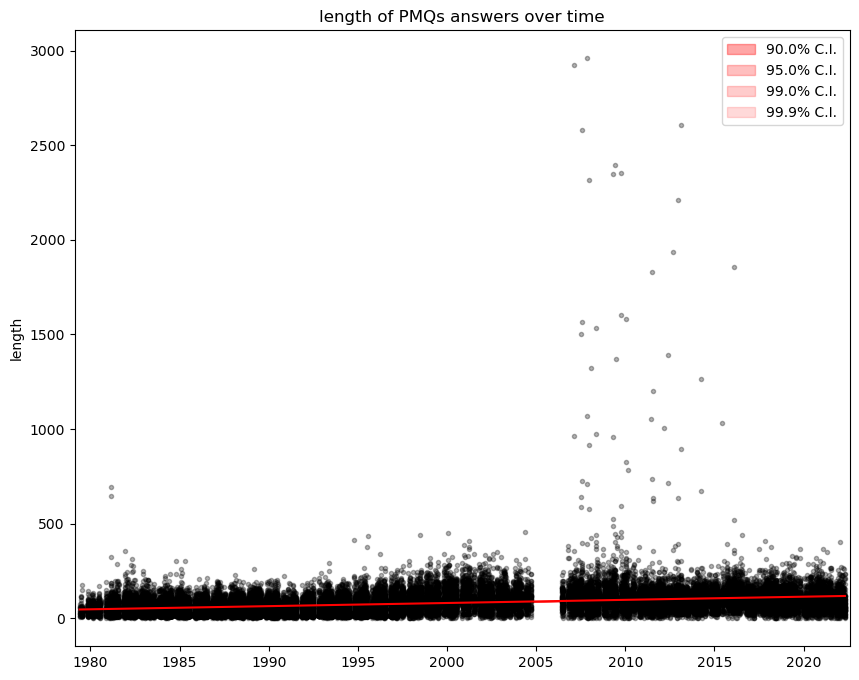

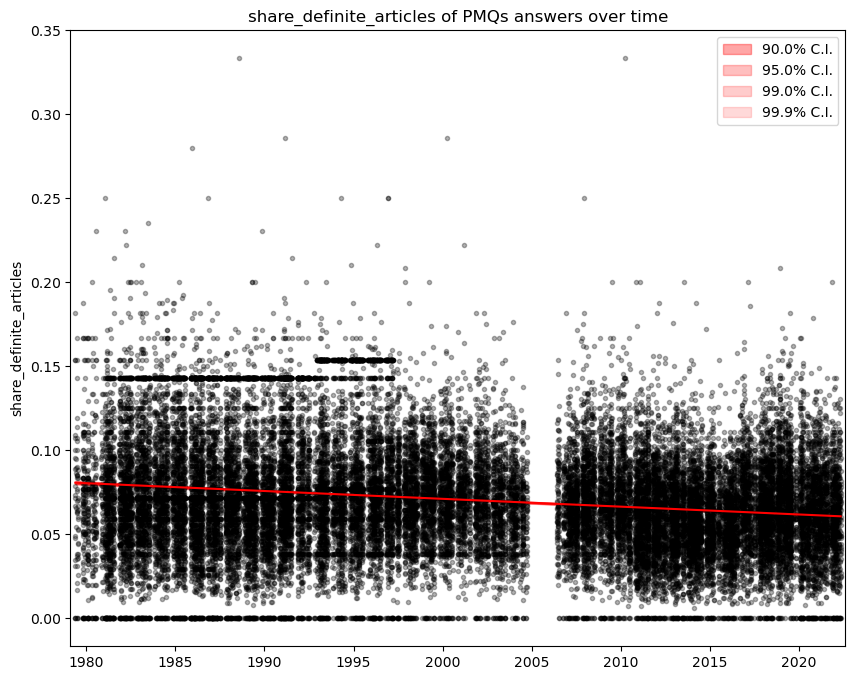

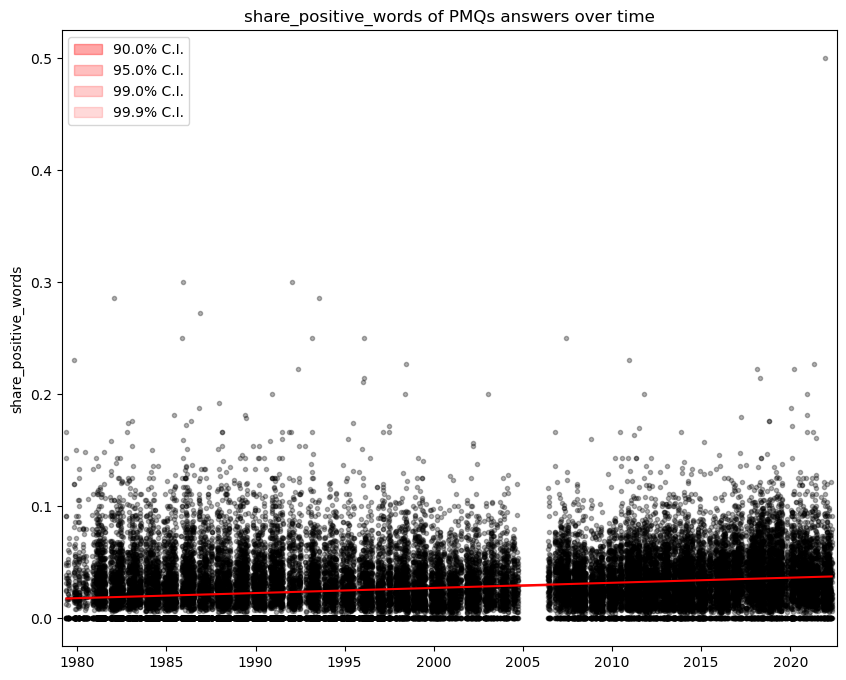

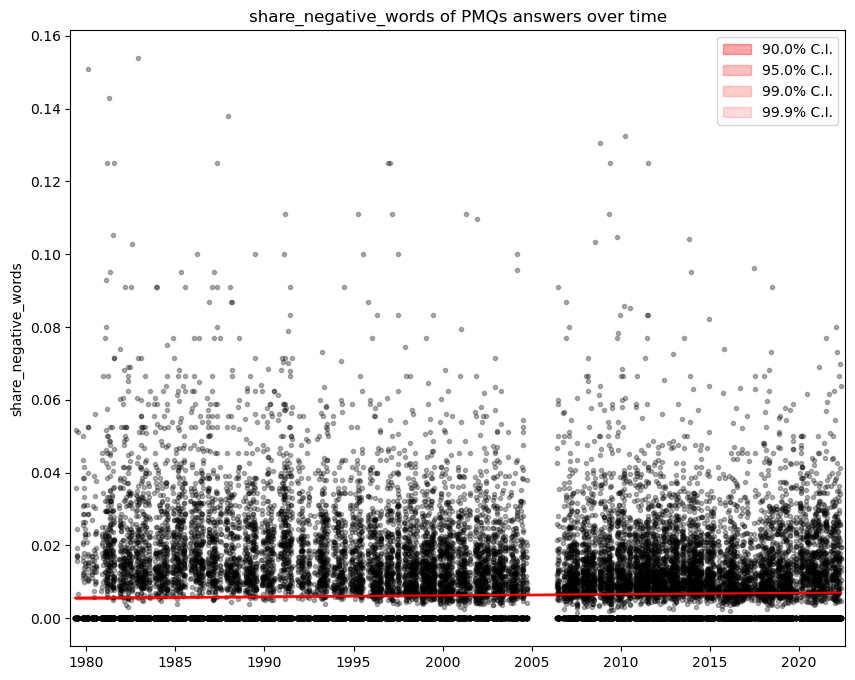

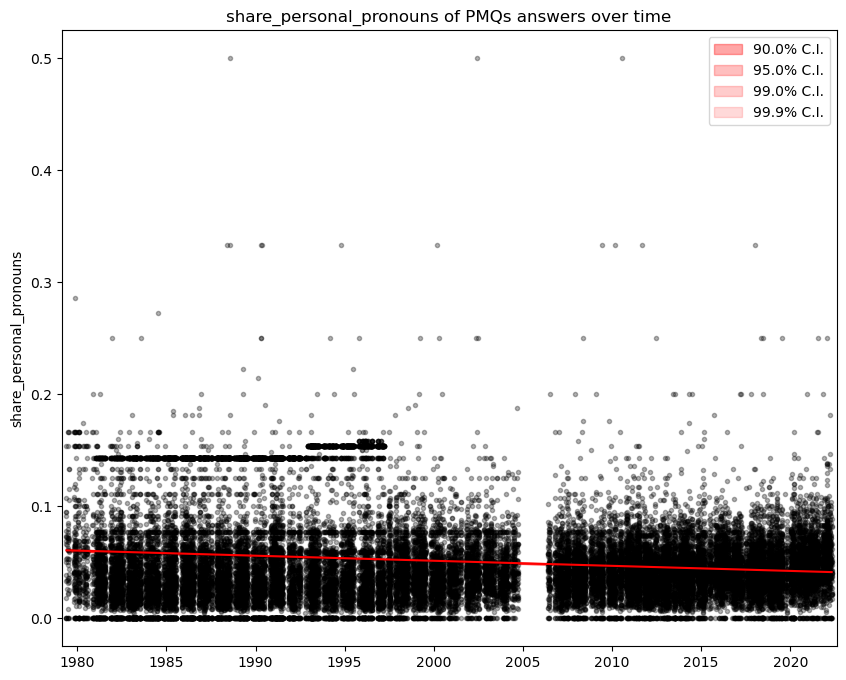

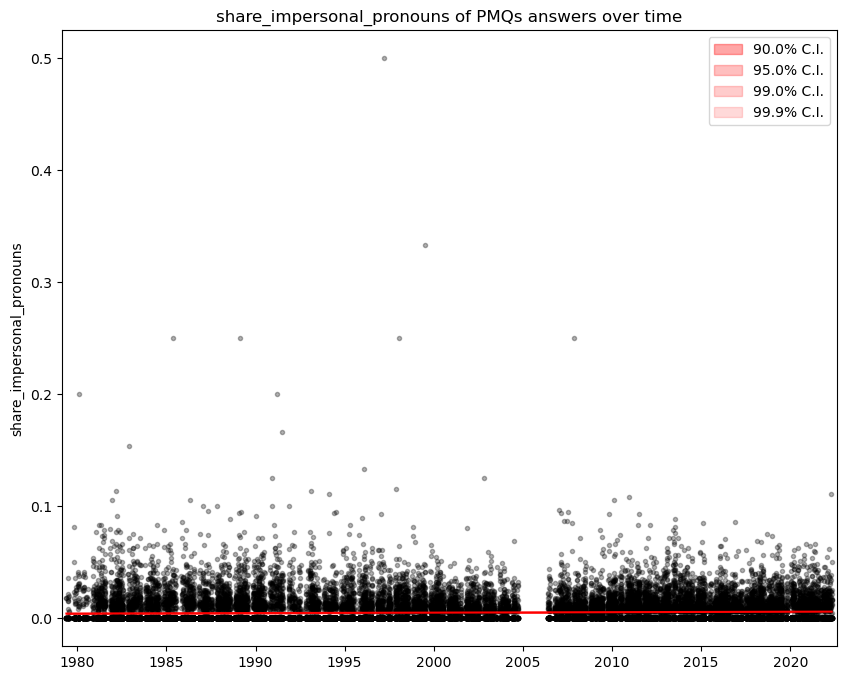

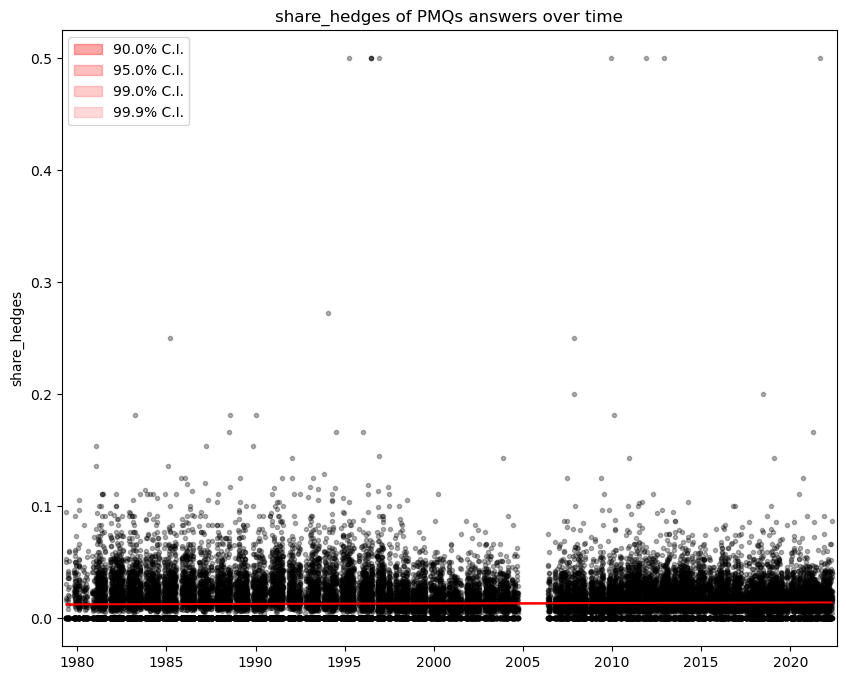

In [121]:
scoring_vars = caw_persuasion_scores[0].keys()

alpha = 0.05

for scoring_var in scoring_vars:
    conf2alpha = {90.0:1.64,
                  95.0:1.96,
                  99.0:2.58,
                  99.9:3.29}
    
    deg = 1
    x = np.array([date for date in pmqs.drop(nan_mask, axis=0).date])
    y = np.array([score_dict[scoring_var] for score_dict in caw_persuasion_scores])
    native_x = [int(xi.timestamp() * 10**9) for xi in x] # convert x to native timestamp
    coefs,cov = np.polyfit(native_x, y, deg=deg, cov=True)
    
    xseq = np.linspace(min(native_x)-1, max(native_x)+1, num=500)
    
    XX = np.vstack([xseq**(deg-i) for i in range(deg+1)]).T # rows 1, x, x**2, ...
    yseq = np.dot(XX, coefs)  # matrix multiplication by coefs calculates the polynomial values
    y_var = np.dot(XX, np.dot(cov, XX.T)) # y_var = XX*C_x*XX'
    y_sig = np.sqrt(np.diag(y_var))  # std. dev. are sqrt of diagonal  
    
    fig,ax = plt.subplots(1, figsize=(10,8))
    
    ax.plot(x, y, '.', color='black', alpha=0.3)
    
    ax.fill_between(pd.to_datetime(xseq), yseq+(conf2alpha[90.0]*y_sig), yseq-(conf2alpha[90.0]*y_sig), alpha=.35, color='red', label='90.0% C.I.')
    ax.fill_between(pd.to_datetime(xseq), yseq+(conf2alpha[95.0]*y_sig), yseq-(conf2alpha[95.0]*y_sig), alpha=.25, color='red', label='95.0% C.I.')
    ax.fill_between(pd.to_datetime(xseq), yseq+(conf2alpha[99.0]*y_sig), yseq-(conf2alpha[99.0]*y_sig), alpha=.20, color='red', label='99.0% C.I.')
    ax.fill_between(pd.to_datetime(xseq), yseq+(conf2alpha[99.9]*y_sig), yseq-(conf2alpha[99.9]*y_sig), alpha=.15, color='red', label='99.9% C.I.')
    ax.plot(pd.to_datetime(xseq), yseq, color='red')
    ax.set_xlim(min(x)-timedelta(days=100), max(x)+timedelta(days=100))
    ax.set_ylabel(scoring_var)
    ax.set_title(scoring_var+" of PMQs answers over time")
    plt.legend()
    plt.show()